# The Basics of TOAD

Welcome to TOAD! Let's get started.

TOAD (Tipping and Other Abrupt events Detector) is a Python framework for detecting and analyzing abrupt shifts in gridded Earth-system data. It implements a three-stage pipeline: (1) detecting abrupt shifts at each grid cell, (2) clustering these shifts in space and time to identify coherent regions of change, and (3) synthesizing results across multiple models, variables, or ensemble members to identify robust patterns.

This tutorial demonstrates TOAD's core functionality using Antarctic Ice Sheet simulation data, showing you how to detect abrupt ice-sheet thinning events and identify spatially coherent collapse regions.


In [30]:
# Prerequisites
import matplotlib.pyplot as plt
import xarray as xr

plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = (12, 6)

### Test data

To demonstrate TOAD we use a dataset from Antarctic Ice Sheet hysteresis simulations performed with the Parallel Ice Sheet Model (PISM). The simulation applies a prescribed global mean surface temperature warming from 0 to ~14°C above pre-industrial levels at a rate of 10⁻⁴ °C yr⁻¹, with the ice sheet remaining close to equilibrium throughout. This makes the dataset ideal for identifying abrupt transitions in ice thickness.

The simulation data are used here under the terms of the Creative Commons Attribution 4.0 International License (CC BY 4.0). Any use of data derived from this source must include proper attribution to the original publication:

Garbe, J., Albrecht, T., Levermann, A., Donges, J. F., and Winkelmann, R.: The hysteresis of the Antarctic Ice Sheet, Nature, 585(7826), 538–544, https://doi.org/10.1038/s41586-020-2727-5, 2020.


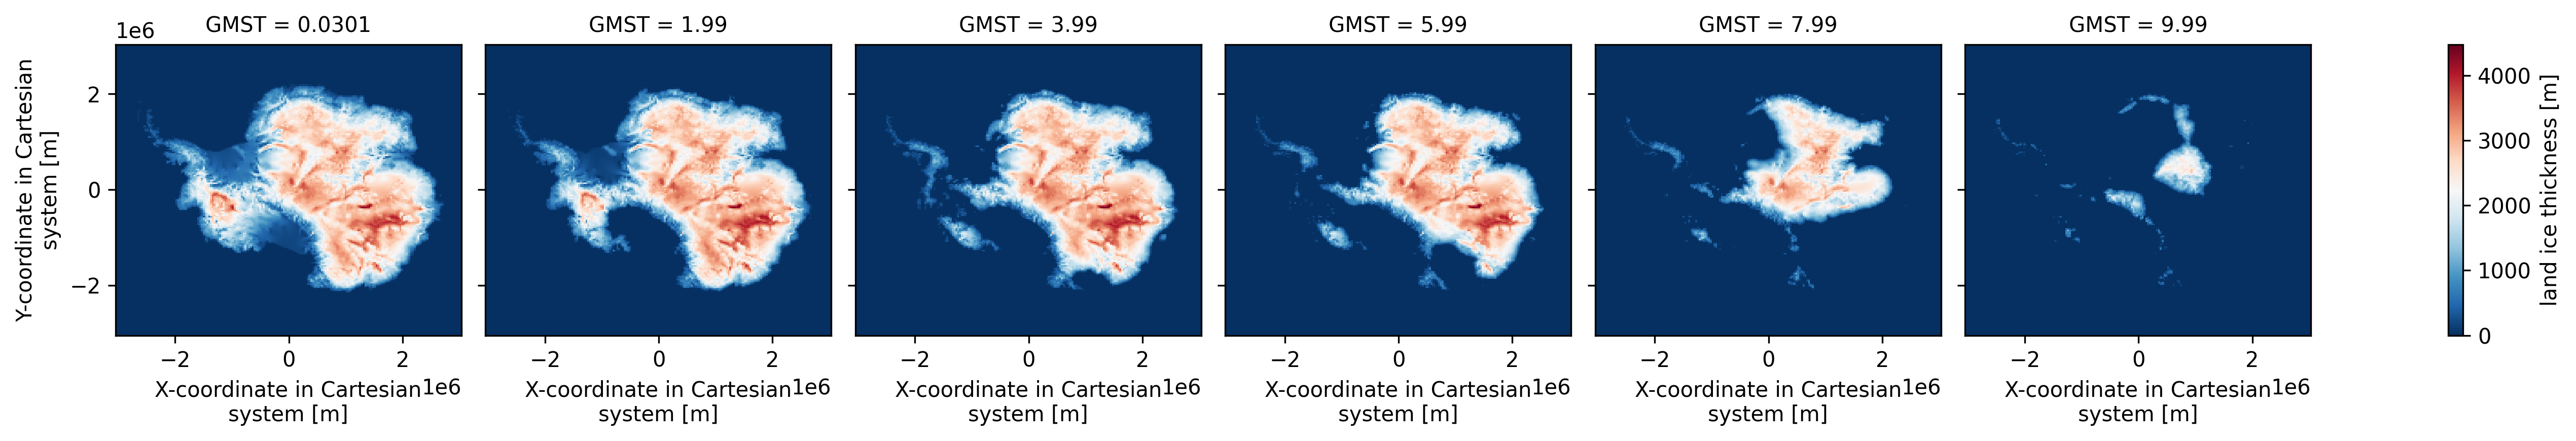

In [31]:
xr.load_dataset("test_data/garbe_2020_antarctica.nc").thk.sel(
    GMST=[0, 2, 4, 6, 8, 10], method="nearest"
).plot(col="GMST", cmap="RdBu_r")

### Init the TOAD object an .nc file

TOAD works on spatio-temporal data. If you time dimension is not called "time", you need to tell TOAD, as done below:


In [32]:
from toad import TOAD

td = TOAD("test_data/garbe_2020_antarctica.nc", time_dim="GMST")

### Step 1: Compute shifts

- First we need an **abrupt shifts detection method**: TOAD currently provides an implemention of `ASDETECT` ([Boulton & Lenton, 2019](https://ore.exeter.ac.uk/repository/handle/10871/40431)).
- See the [asdetect.py](../toad/shifts/methods/asdetect.py) docstring for a brief description.
- You can also implement your own shifts detection algorithm, see [shift_detection_methods.ipynb](../tutorials/shift_detection_methods.ipynb) for details.


In [33]:
from toad.shifts import ASDETECT

# the test data already contains computed shifts, so let's just drop them
td.drop_shifts()

# define variable and method
td.compute_shifts(var="thk", method=ASDETECT(timescale=(0.5, 3.5)))

# ~12 seconds

Shift detection (36100 grid cells in 32 blocks): 100%|██████████| 32/32 [00:13<00:00,  2.44it/s]
INFO: New shifts variable thk_dts: min/mean/max=-1.000/-0.227/1.000 using 13901 grid cells. Skipped 61.5% grid cells: 0 NaN, 22199 constant.


#### Quick illustration of ASDETECT output


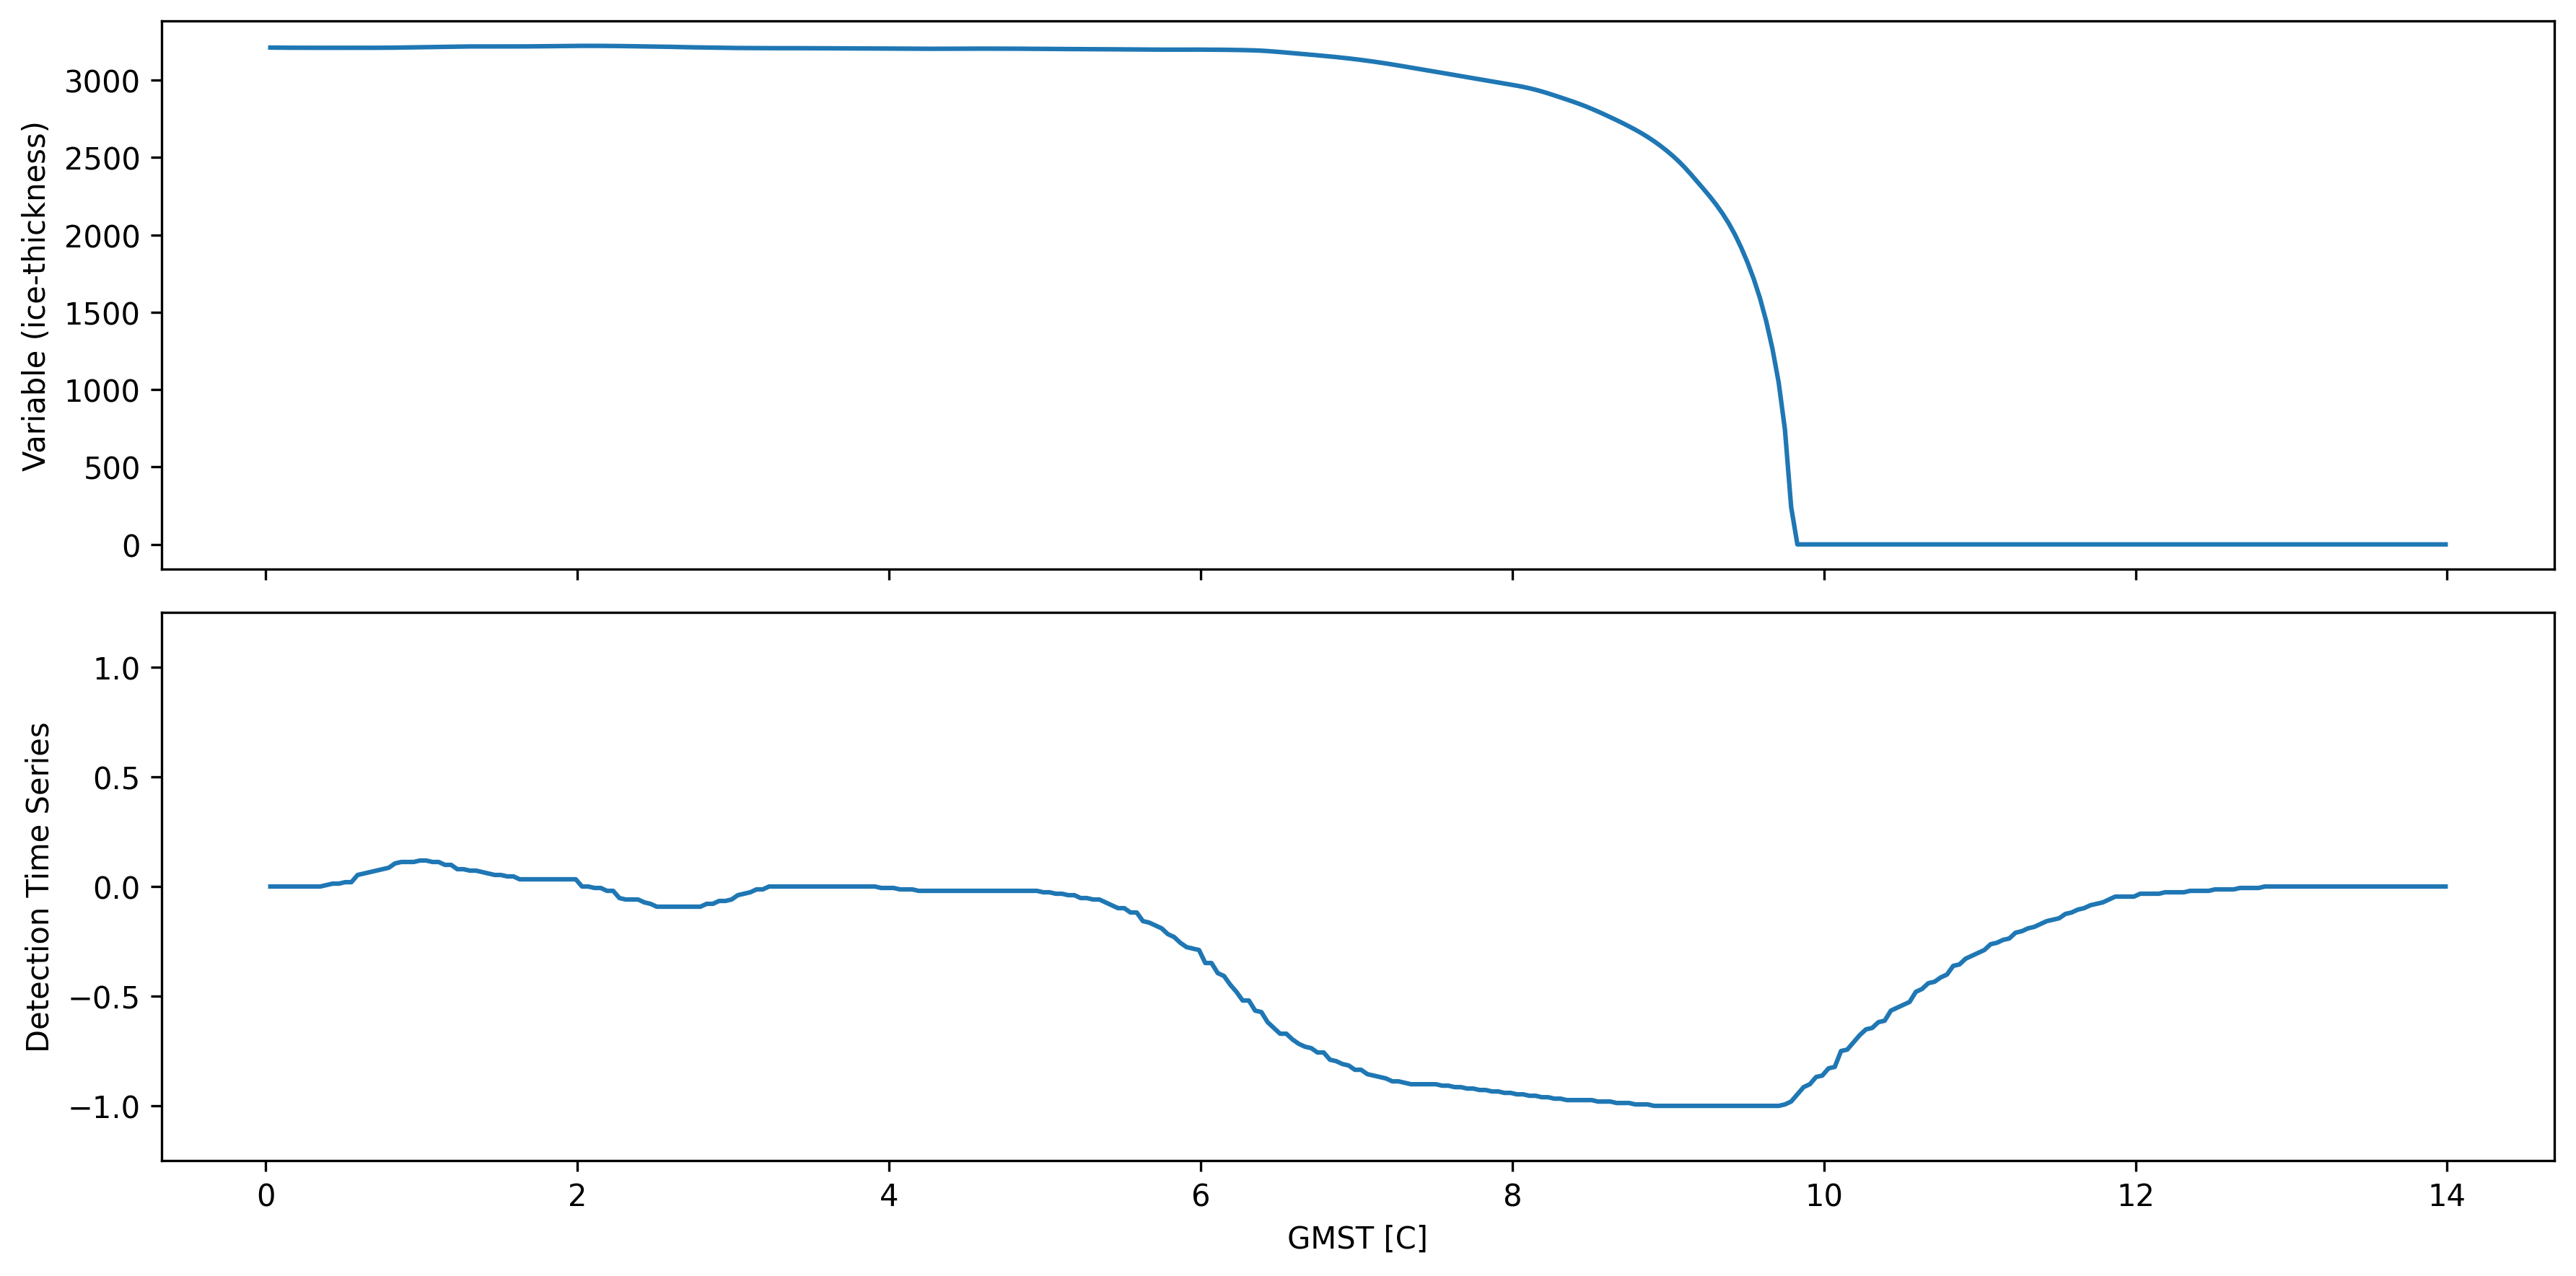

In [34]:
fig, axs = plt.subplots(2, sharex=True)
idx, idy = 100, 90
td.data.thk.isel(x=idx, y=idy).plot(ax=axs[0])
td.data.thk_dts.isel(x=idx, y=idy).plot(ax=axs[1])
axs[0].set_ylabel("Variable (ice-thickness)")
axs[1].set_ylabel("Detection Time Series")
axs[1].set_ylim(-1.25, 1.25)
axs[0].set_title("")
axs[1].set_title("")
axs[0].set_xlabel("")
fig.tight_layout()

## Step 2: Compute Clusters

- Now we need a **clustering method**: TOAD can take any clustering method from the [scikit-learn library](https://scikit-learn.org/stable/api/sklearn.cluster.html),
- We recommend using [HDBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html#sklearn.cluster.HDBSCAN) which has intuitive hyperparameters and supports clusters of different densities. Tip: For large datasets [fast_hdbscan](https://github.com/TutteInstitute/fast_hdbscan) can be significantly faster.
- You can also write your own clustering algorithm, see [clustering_methods.ipynb](../tutorials/clustering_methods.ipynb) for details.


In [35]:
from sklearn.cluster import HDBSCAN

td.data = td.data.drop_vars(td.cluster_vars)

td.compute_clusters(
    var="thk",  # reference your base variable, TOAD will find computed shifts for this variable
    method=HDBSCAN(min_cluster_size=15),
    time_weight=2.0,
)

INFO: New cluster variable thk_dts_cluster: Identified 79 clusters in 16,636 pts; Left 30.0% as noise (4,987 pts).


**Calling the TOAD object** gives you an overview of current computed variables:

For the "base variable" `thk`, we now have "shifts variable" `thk_dts` and "cluster variable" `thk_dts_cluster`.


In [36]:
td

In [37]:
# You can find all method parameters used for the computation in the attributes, e.g:
td.data.thk_dts.attrs

{'standard_name': 'land_ice_thickness',
 'long_name': 'land ice thickness',
 'units': 'm',
 'pism_intent': 'model_state',
 'time_dim': 'GMST',
 'method_name': 'ASDETECT',
 'toad_version': '0.3',
 'base_variable': 'thk',
 'variable_type': 'shift',
 'method_ignore_nan_warnings': 'False',
 'method_lmin': '5',
 'method_segmentation': 'two_sided',
 'method_timescale': '(0.5, 3.5)'}

#### Let's **plot** the result:

TOAD supplies three plotting functions:

- `td.plot.overview()`

- `td.plot.cluster_map()`

- `td.plot.timeseries()`


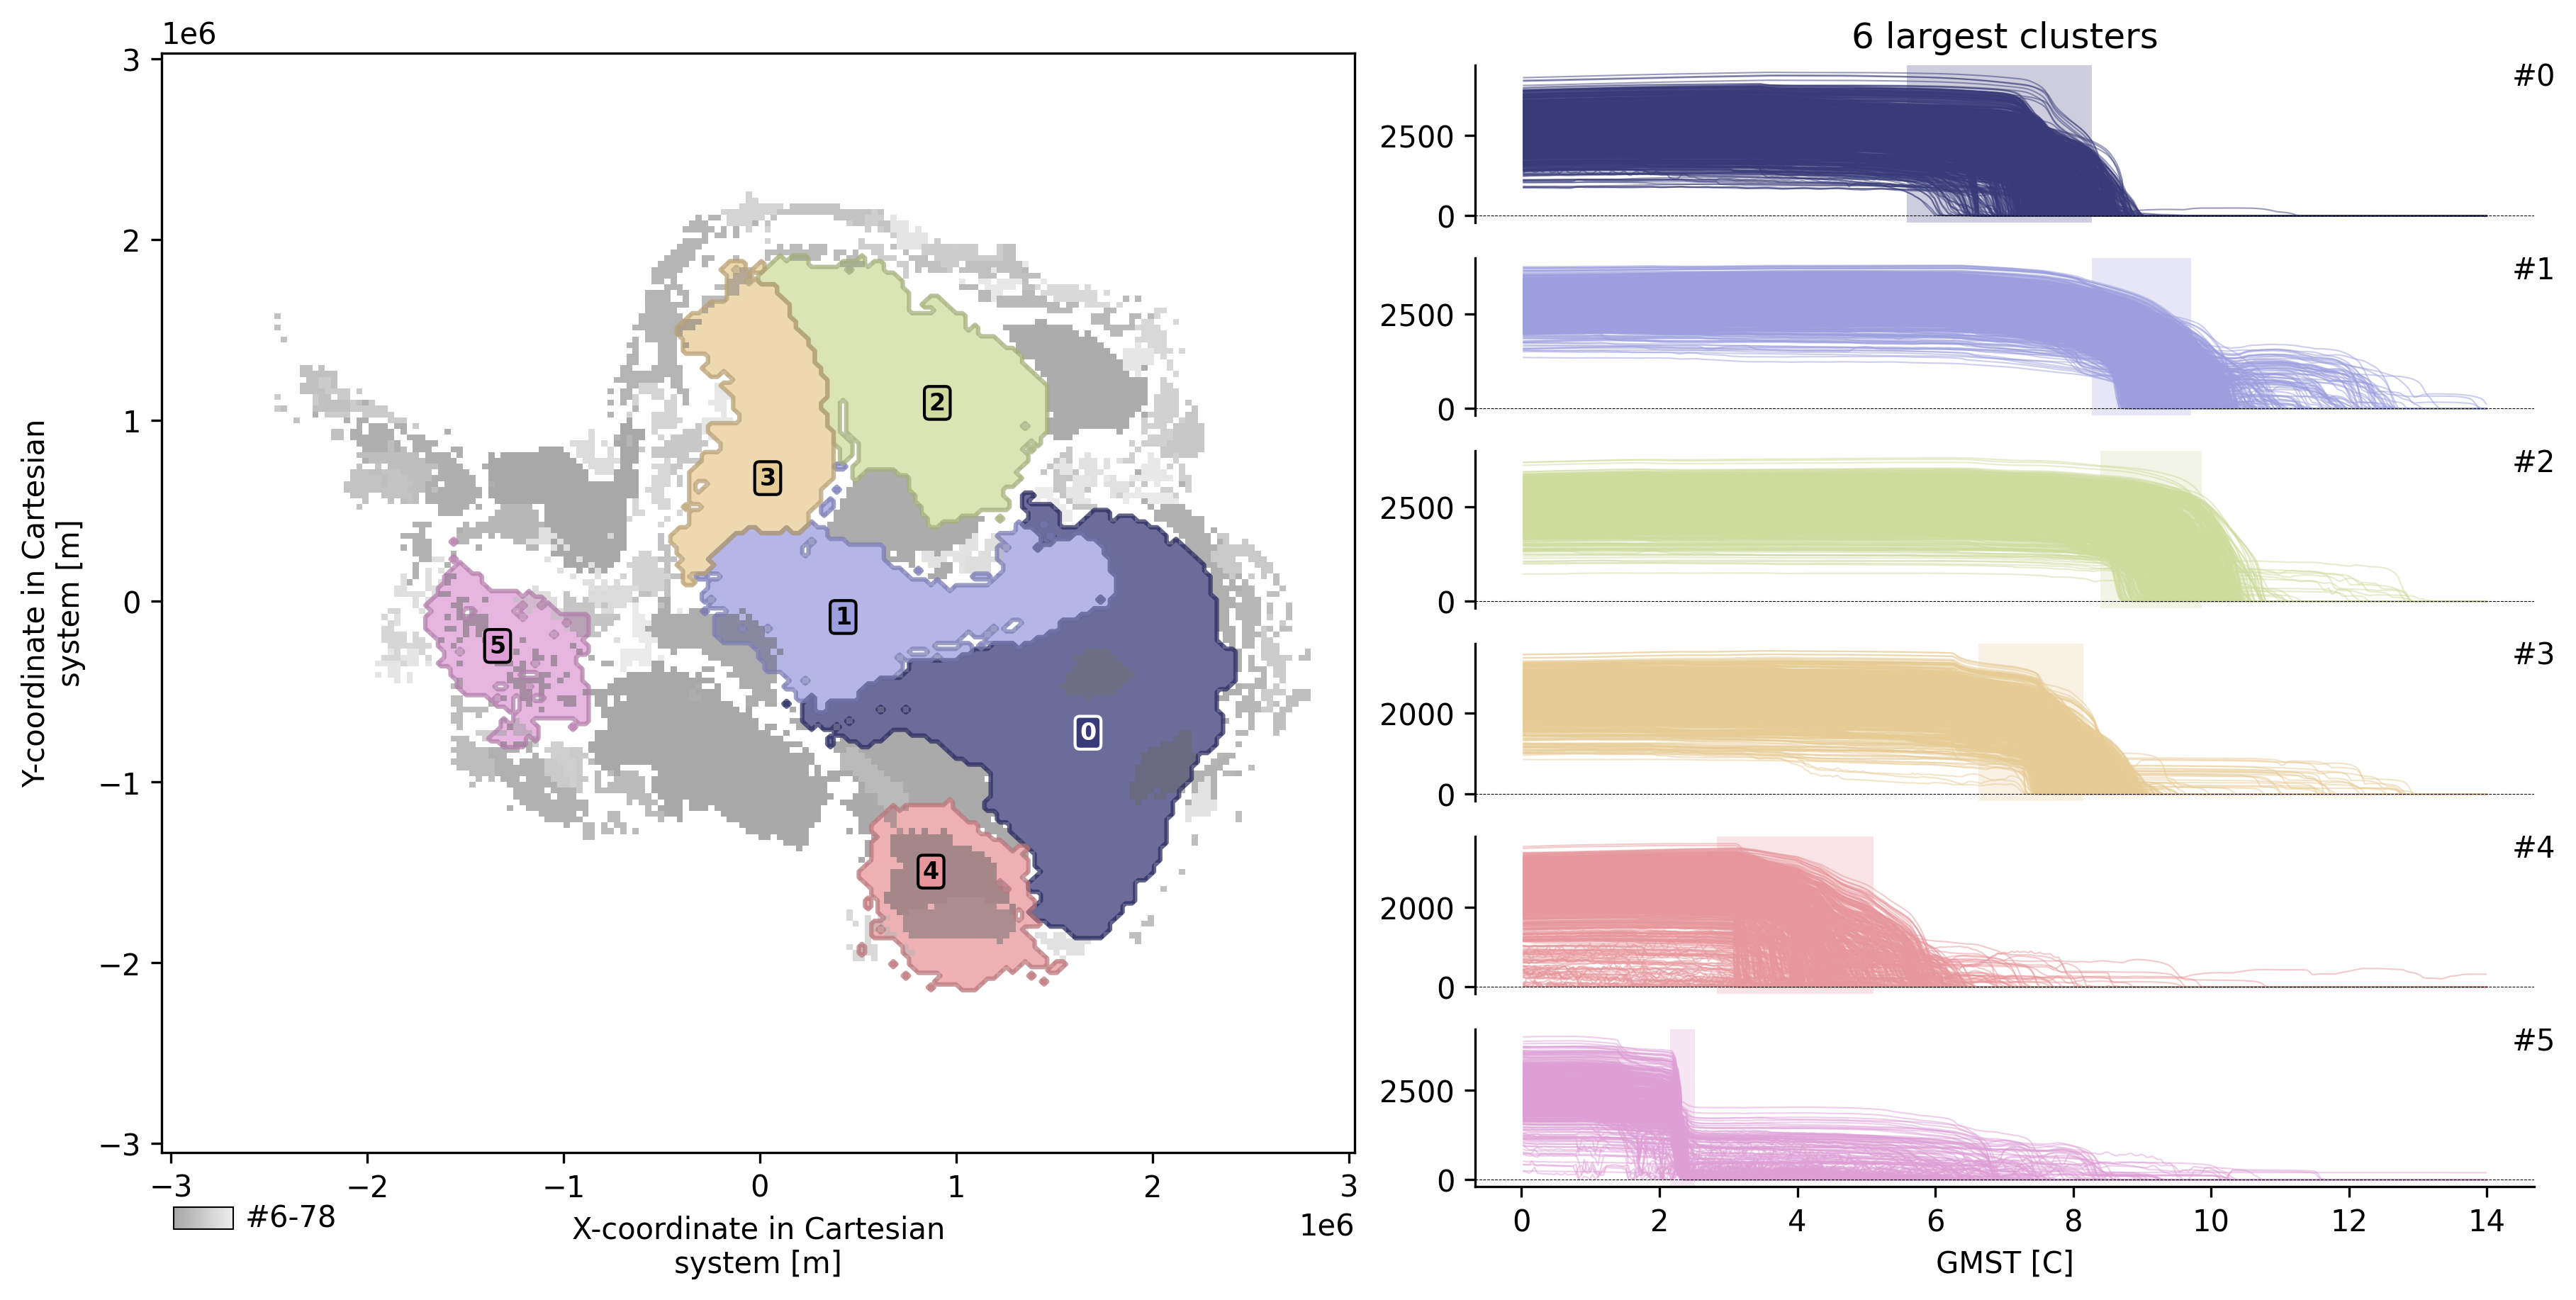

In [38]:
td.plot.overview();

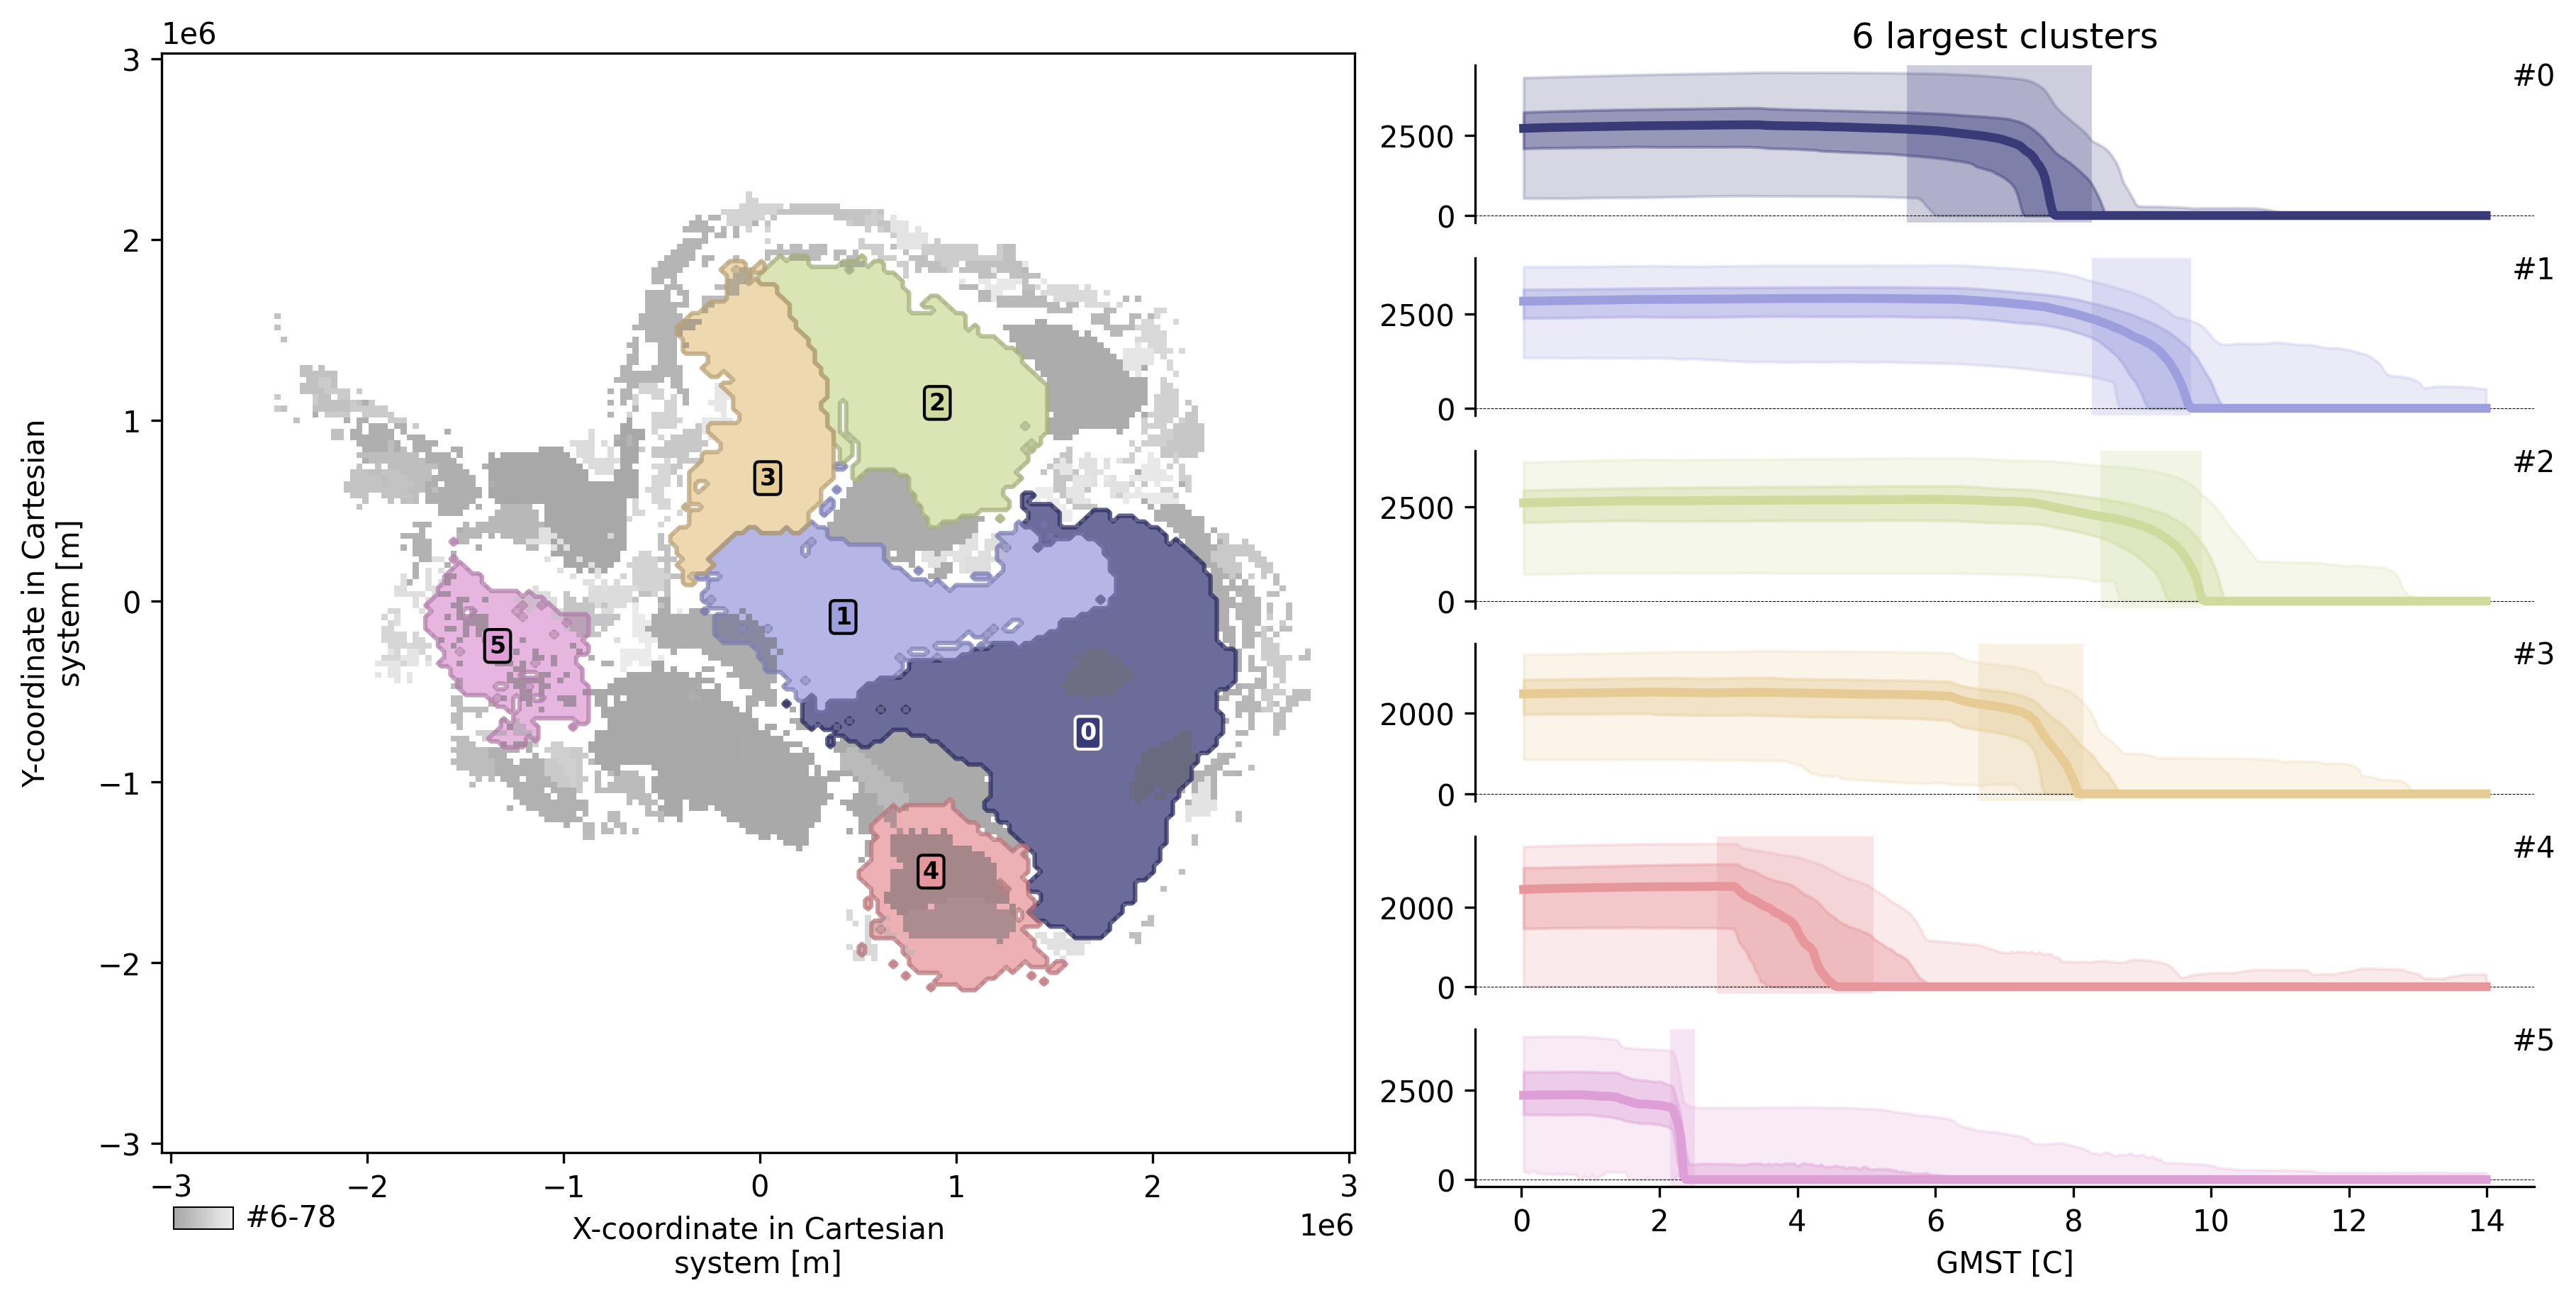

In [39]:
td.plot.overview(mode="aggregated");

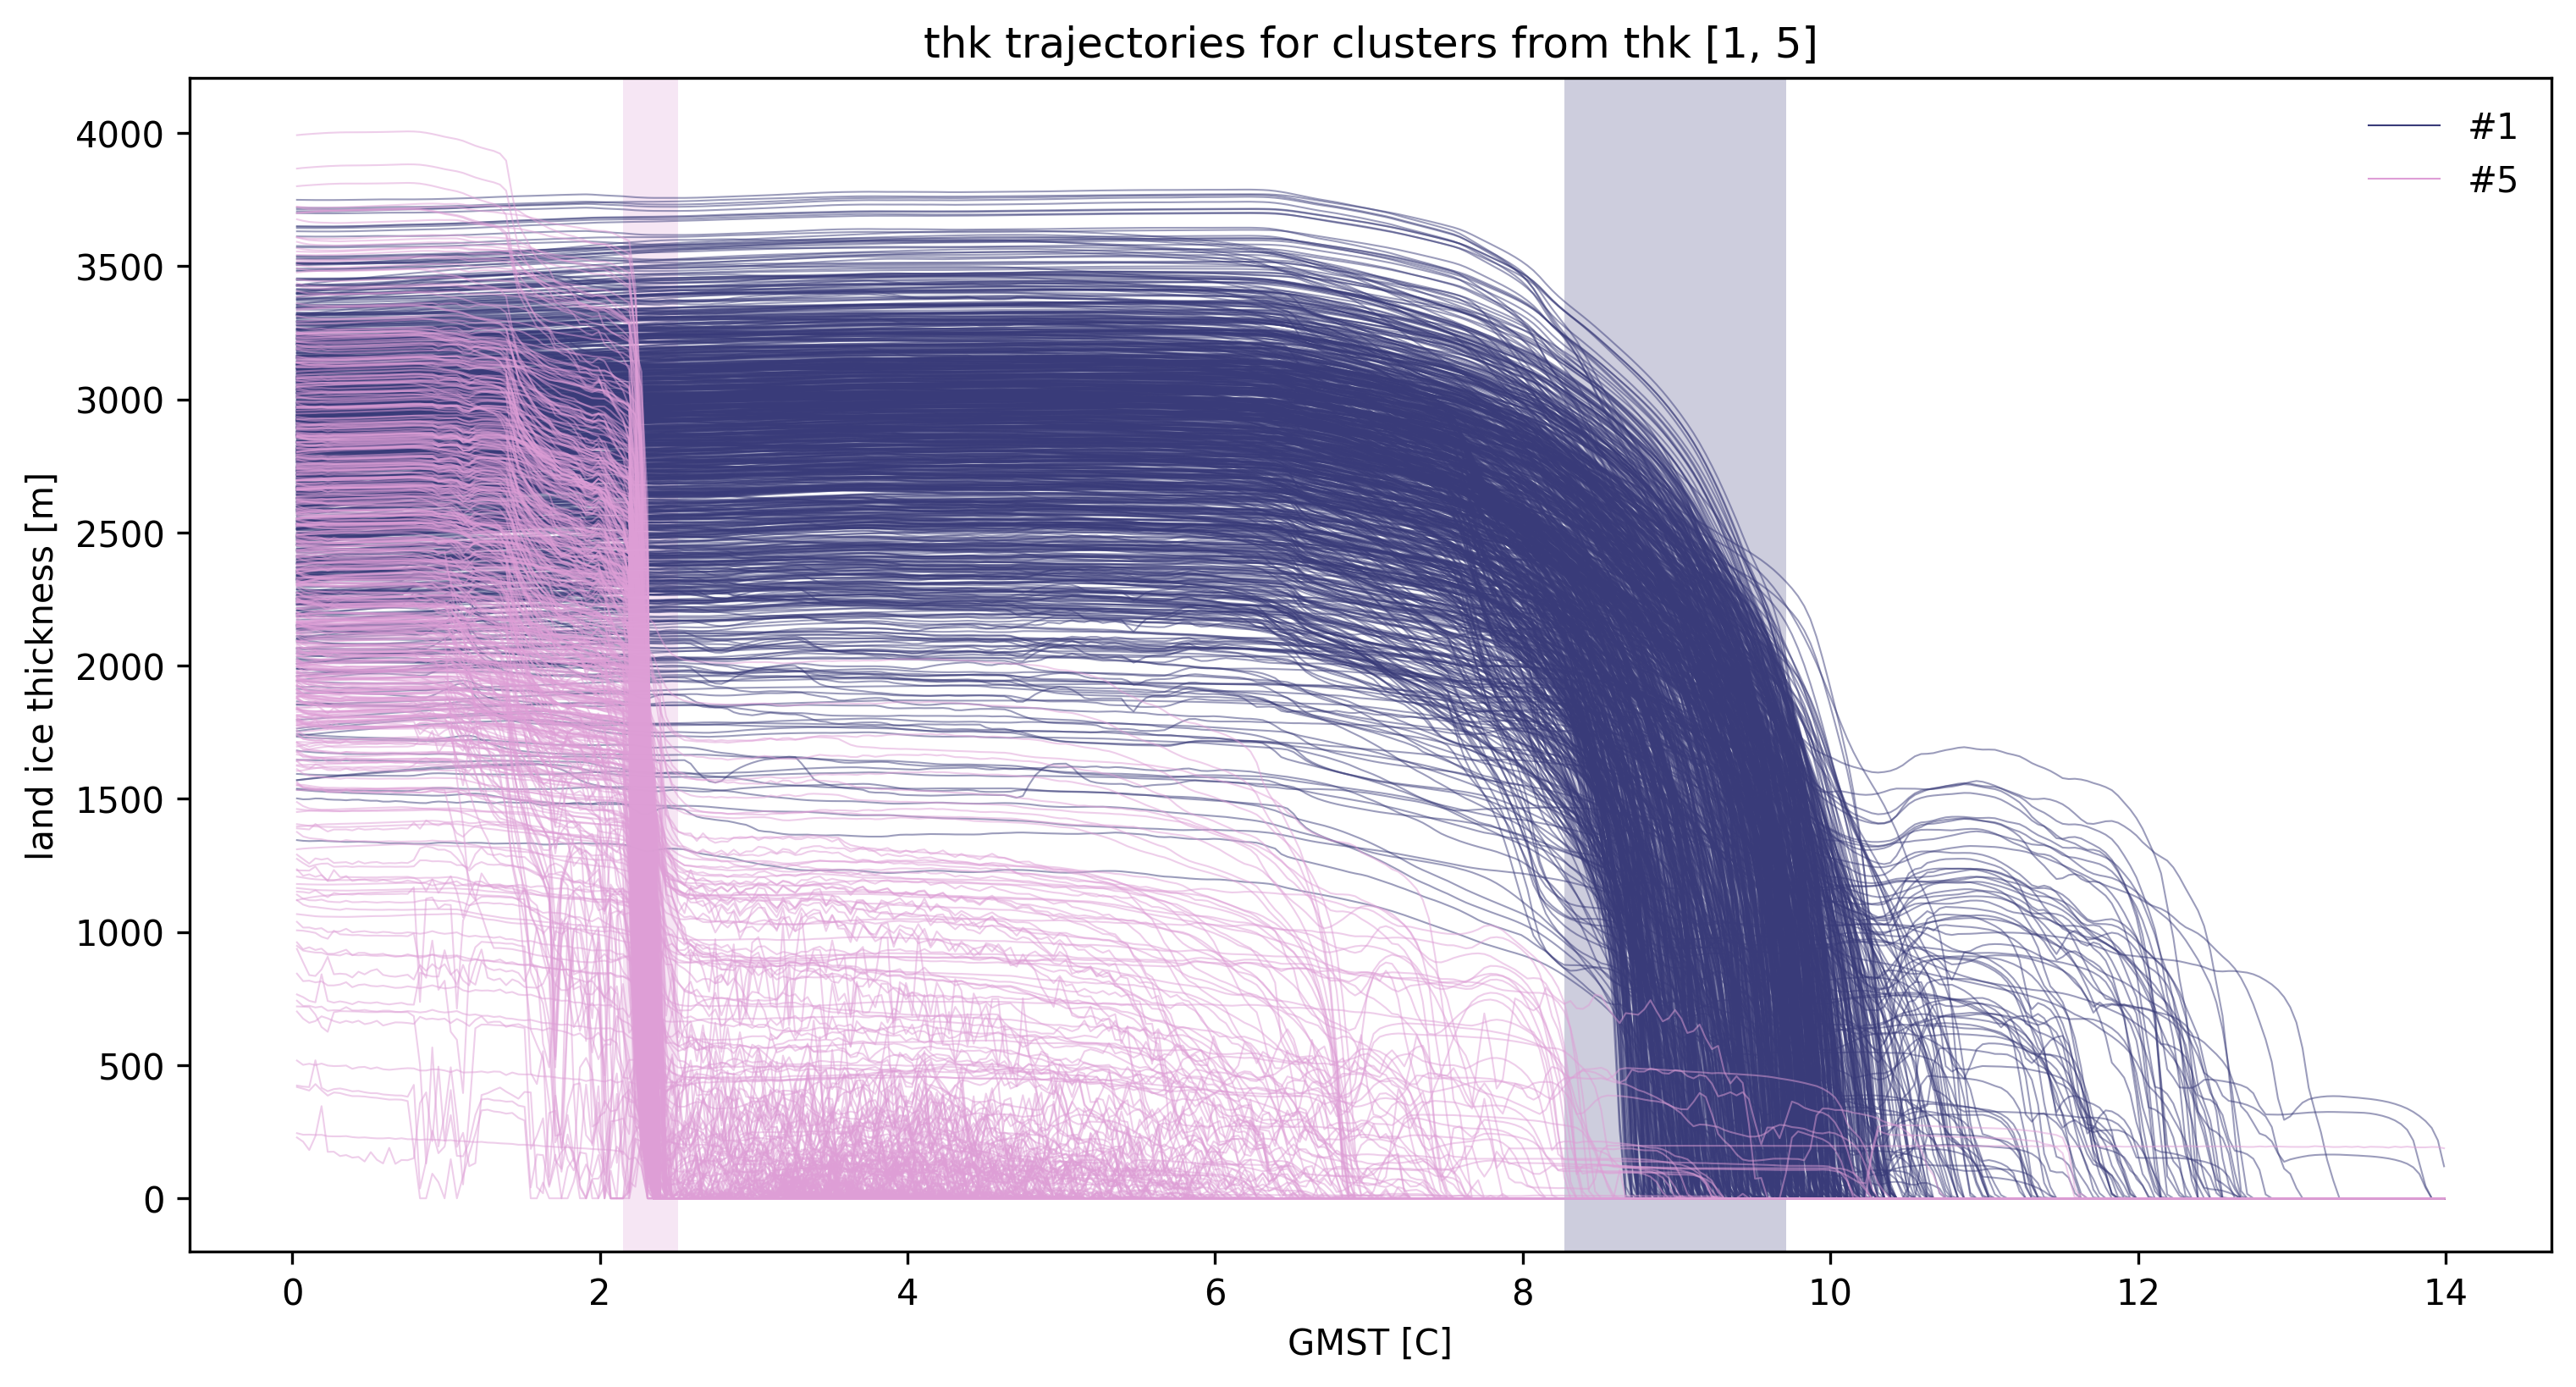

In [40]:
td.plot.timeseries(cluster_ids=[1, 5]);

Customize the map with the `map_style` param.


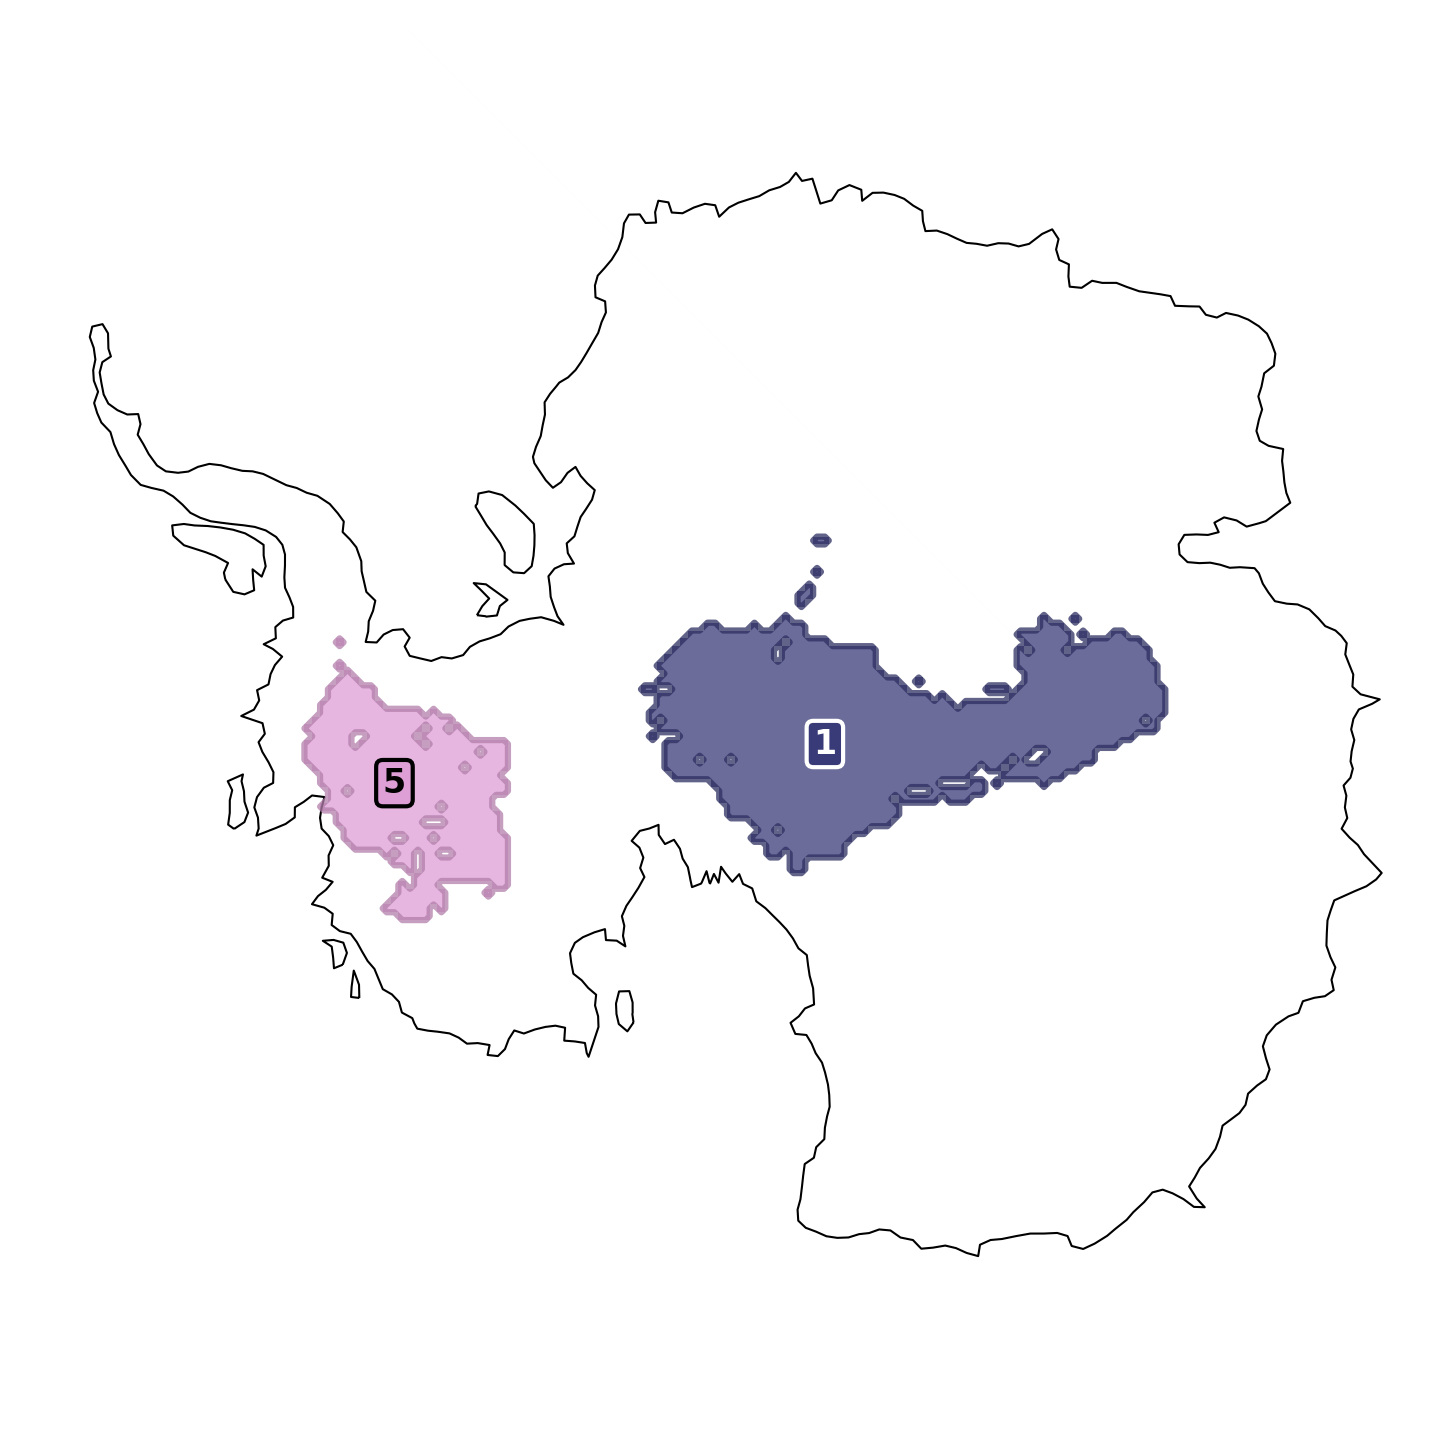

In [41]:
from toad import MapStyle

fig, ax = td.plot.cluster_map(
    cluster_ids=[1, 5],
    include_all_clusters=False,
    map_style=MapStyle(projection="south_pole", grid_lines=False),
)
ax.set_axis_off()

We can also see a map of the time/forcing level of the maximum detected shift. This already gives a feeling for the structures that we see in the clusters.


(<Figure size 3600x1800 with 2 Axes>,
 <GeoAxes: title={'center': 'Time of maximum shift for thk'}, xlabel='x', ylabel='y'>)

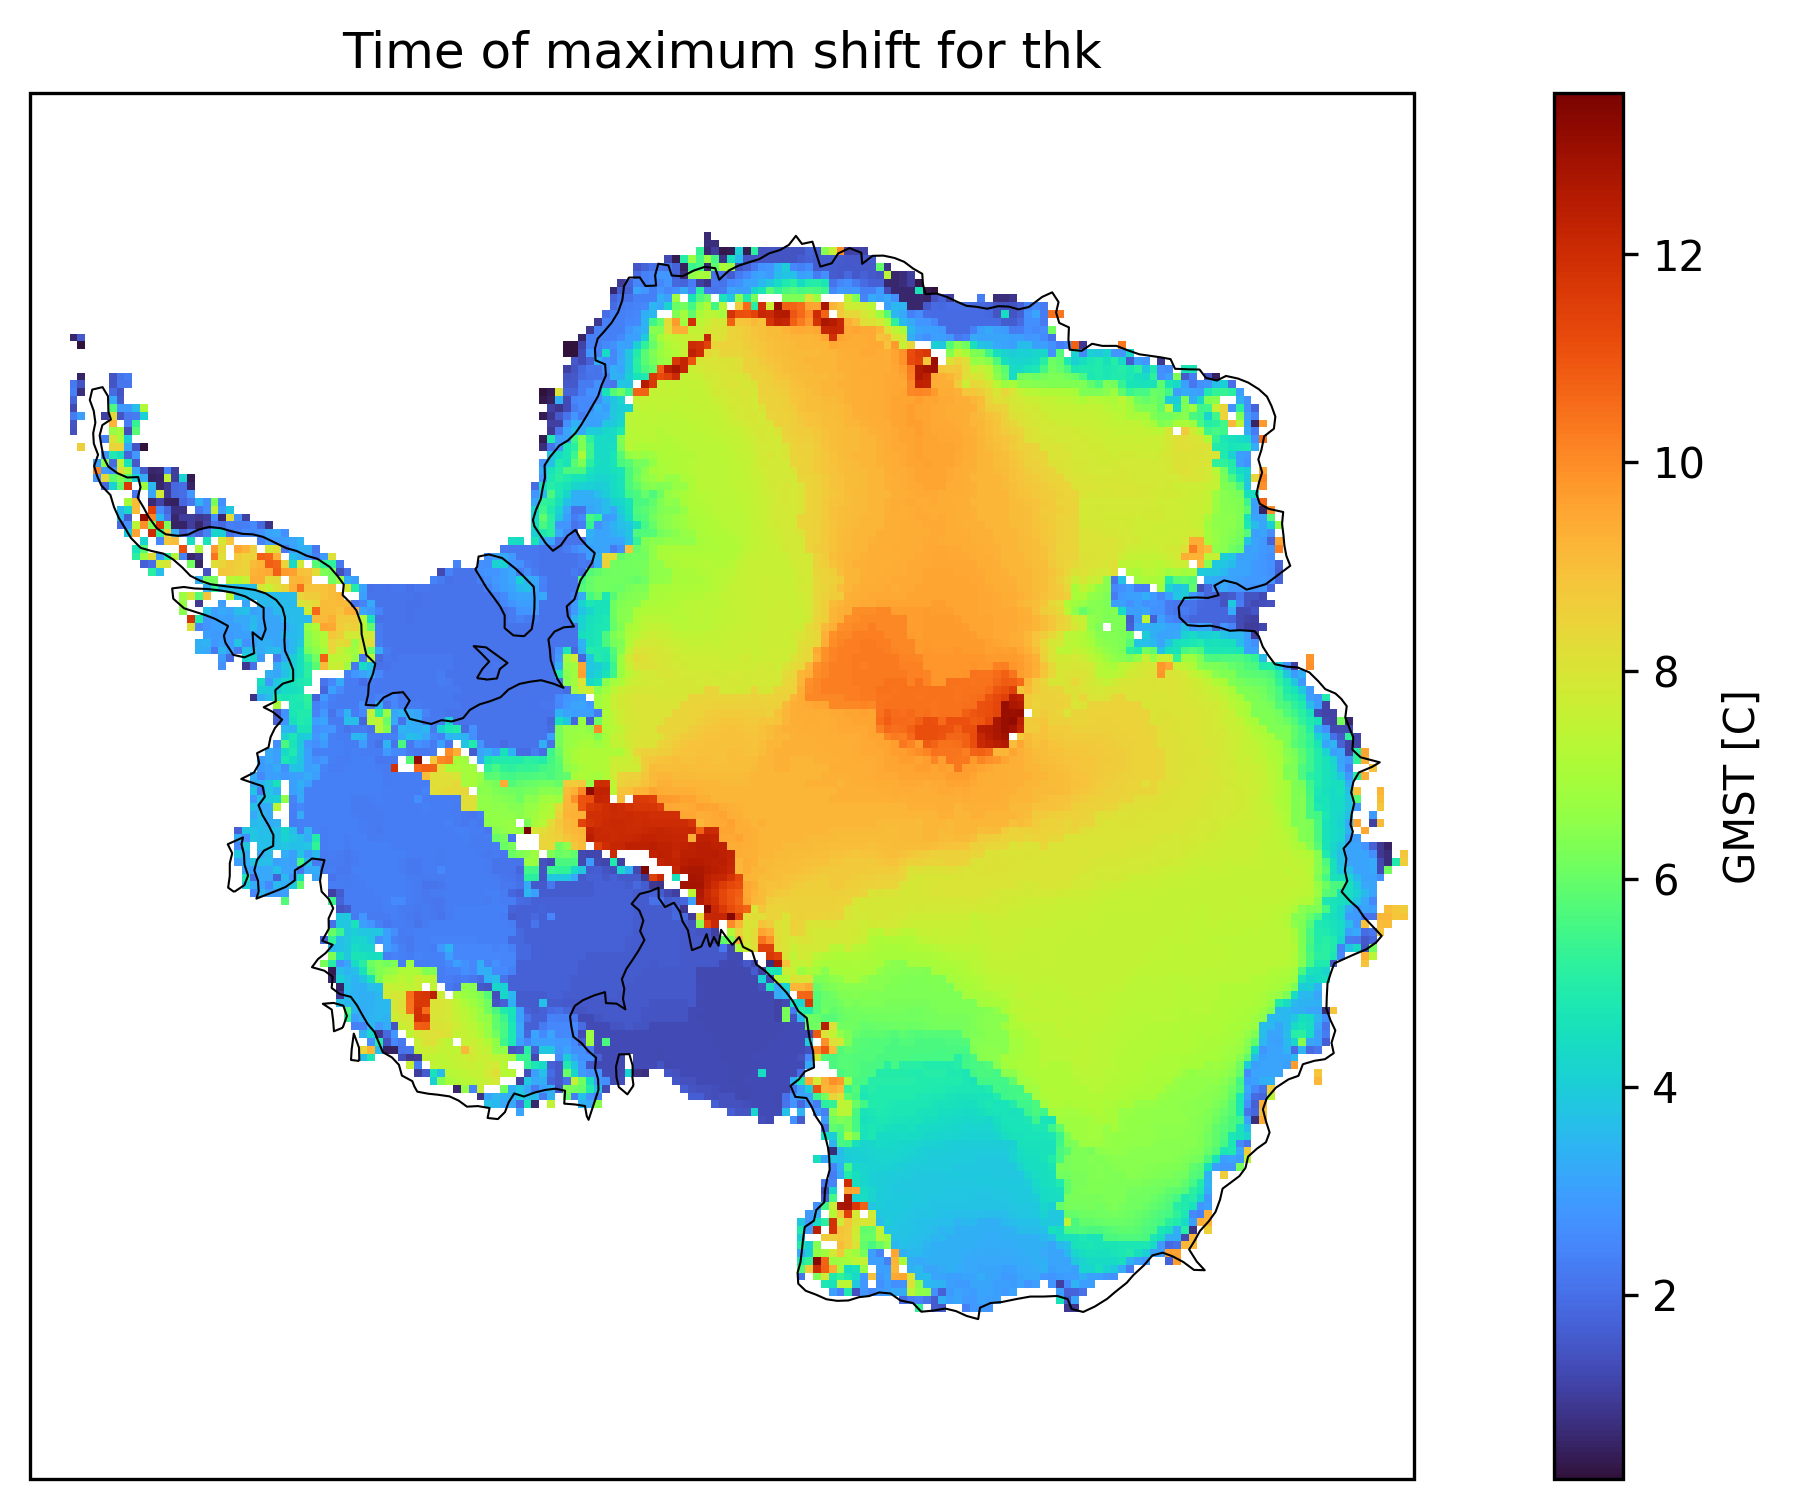

In [42]:
td.plot.time_of_max_shift_map(
    "thk", map_style=MapStyle(projection="south_pole", grid_lines=False)
)

#### Save your results


Save the dataset with the new additions using the `td.save()` function. This automatically adds compression.


In [43]:
# Use original path name with suffix
# td.save(suffix="_my_computed_toad_data")

# Use a different path name
# td.save(path="my_computed_toad_data.nc")

#### Export cluster masks


In [44]:
mask = td.get_cluster_mask_spatial("thk", cluster_id=1)
mask

<xarray.DataArray 'thk_dts_cluster' (y: 190, x: 190)> Size: 36kB
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], shape=(190, 190))
Coordinates:
  * y        (y) float64 2kB -3.032e+06 -3e+06 ... 2.984e+06 3.016e+06
  * x        (x) float64 2kB -3.032e+06 -3e+06 ... 2.984e+06 3.016e+06
Attributes: (12/32)
    standard_name:                     land_ice_thickness
    long_name:                         land ice thickness
    units:                             m
    pism_intent:                       model_state
    time_dim:                          GMST
    method_name:                       HDBSCAN
    ...                                ...
    method_cluster_selection_epsilon:  0.0
    method_cluster_selection_method:   eom
    method_copy:                       False
    method_leaf_size:                  40
    method_metric:                     euclidean
    method_min_cluster_size:           15

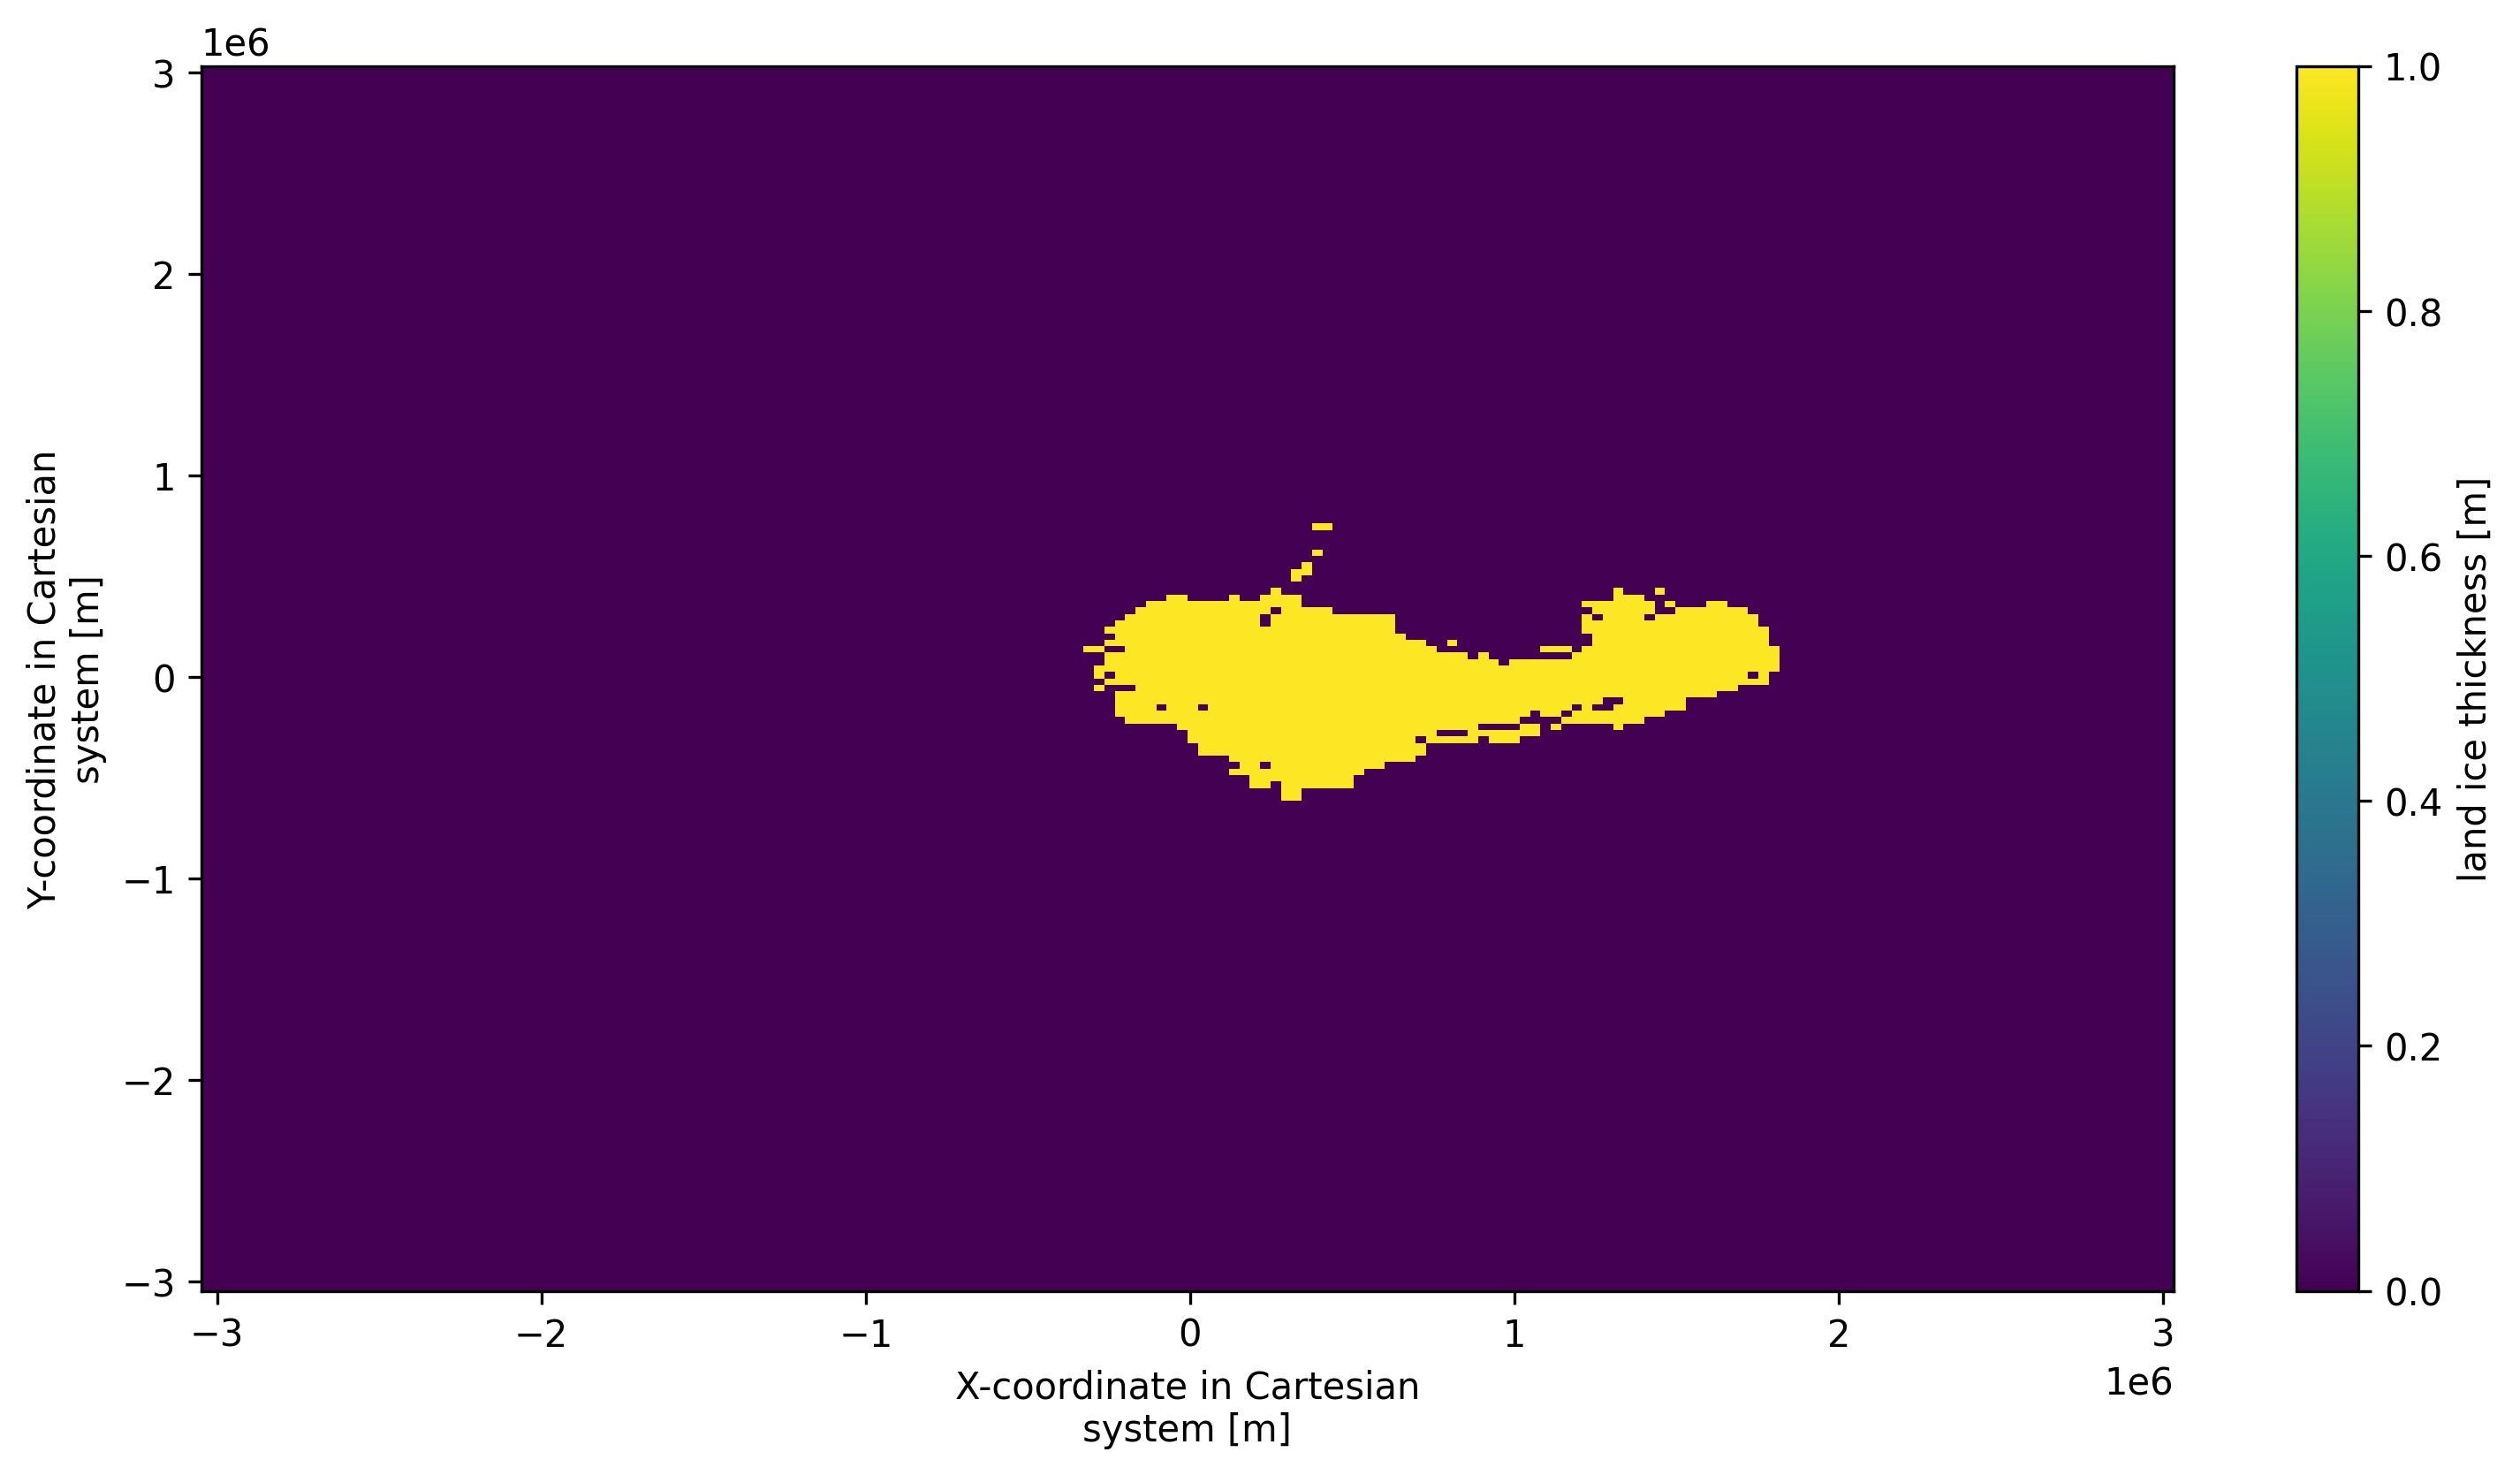

In [45]:
mask.plot()  # type: ignore

#### Access Timeseries in Clusters


Text(0.5, 1.0, 'Cluster 2')

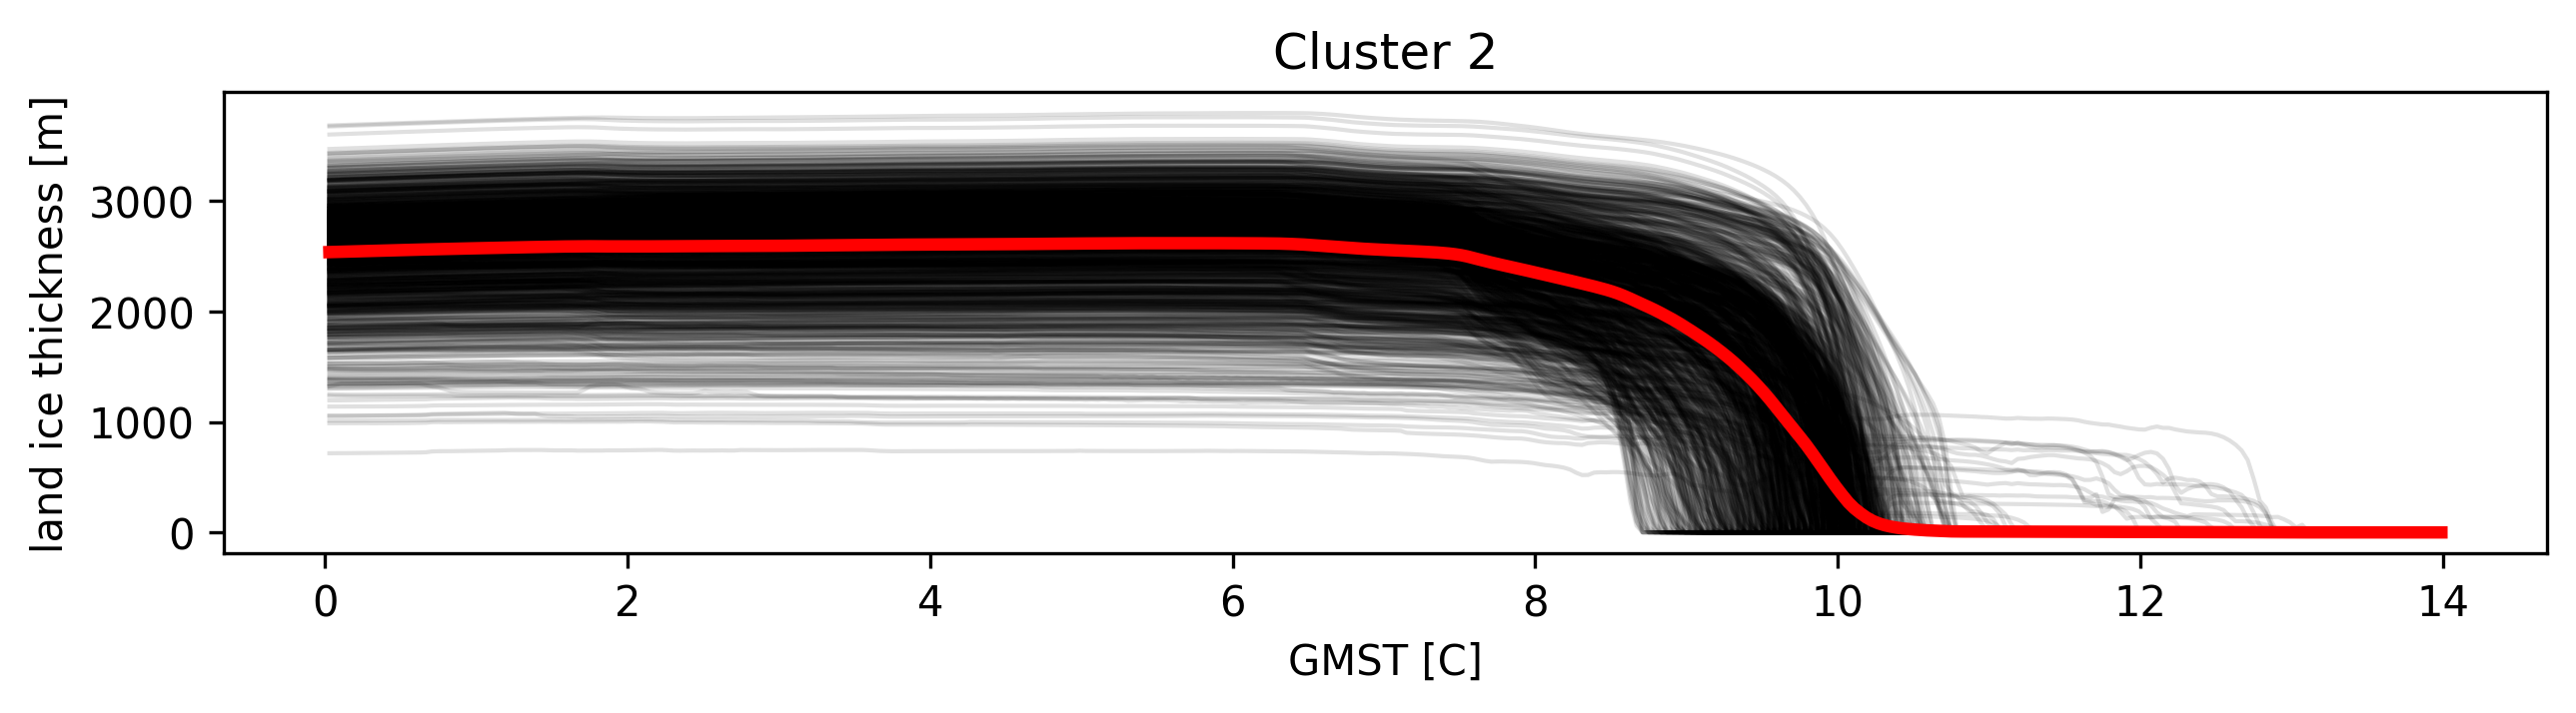

In [46]:
# Get time series from clusters
timeseries = td.get_cluster_timeseries("thk", cluster_id=2)

# get mean of timeseries
mean = td.get_cluster_timeseries("thk", cluster_id=2, aggregation="mean")

# Eg: to plot:
plt.figure(figsize=(10, 2))
for ts in timeseries:
    ts.plot(color="k", alpha=0.12, lw=1)
mean.plot(lw=3, color="r")  # type: ignore
plt.title("Cluster 2")

### Stats

Calling `td.stats(var)` and the submodules `time` and `space` will expose more statistics related helper functions.


#### Time stats


In [47]:
# get start time for cluster 5
td.stats(var="thk").time.start(cluster_id=5)

2.1501

In [48]:
# get all stats in dictionary
td.stats("thk").time.all_stats(5)

{'duration': 0.3600000000000003,
 'duration_timesteps': 9,
 'end': 2.5101000000000004,
 'end_timestep': 62,
 'iqr_50': (2.2701000000000002, 2.3501000000000003),
 'iqr_68': (2.2301, 2.3501000000000003),
 'iqr_90': (2.1901, 2.3501000000000003),
 'mean': 2.314544444444445,
 'median': 2.3101000000000003,
 'membership_peak': 2.2701000000000002,
 'membership_peak_density': 0.005318559556786704,
 'start': 2.1501,
 'start_timestep': 53,
 'std': 0.11066577420434438,
 'steepest_gradient': 2.3101000000000003,
 'steepest_gradient_timestep': 57}

#### Space stats


In [49]:
# Get mean x,y position of cluster 5
td.stats(var="thk").space.mean(cluster_id=5)

(-282661.12266112264, -1269139.293139293)

In [50]:
td.stats("thk").space.all_stats(5)

{'central_point_for_labeling': (-248000.0, -1336000.0),
 'footprint_cumulative_area': 481,
 'footprint_mean': (-282661.12266112264, -1269139.293139293),
 'footprint_median': (-280000.0, -1272000.0),
 'footprint_std': (229008.10144179303, 214851.6466720021),
 'mean': (-282661.12266112264, -1269139.293139293),
 'median': (-280000.0, -1272000.0),
 'std': (229008.101441793, 214851.64667200207)}

#### Cluster scoring

We have a few scores available already that aim to quantify the quality of a cluster.

`score_heaviside()` evaluates how closely the spatially aggregated cluster time series resembles a perfect Heaviside function. A score of 1 indicates a perfect step function, while 0 indicates a linear trend.

`score_consistency()` measures internal coherence using hierarchical clustering. Higher scores indicate more internally consistent clusters, which is useful for assessing cluster quality.

`score_spatial_autocorrelation()` measures average pairwise similarity (R²) between time series within a cluster. Higher scores mean more similar behavior within the cluster. This provides a fast computation of spatial coherence.

`score_nonlinearity()` measures deviation from linearity using RMSE and can be normalized against unclustered data. Higher scores indicate more nonlinear behavior, which is good for detecting complex temporal patterns.


In [51]:
td.stats("thk").general.score_heaviside(5, aggregation="mean")

0.41722873312015085

# Example 2: Synthetic Dataset with Known Shifts

For our second example, we demonstrate TOAD on a synthetically generated dataset with known abrupt shifts. This provides a controlled test case where we can verify that TOAD correctly identifies the spatial regions and timing of predefined transitions.

The synthetic dataset contains:

- A regular lat-lon grid (90 × 180)
- 200 time steps
- White noise background
- Two distinct sigmoid transitions at different times and locations

This example illustrates TOAD's ability to recover known shift patterns, making it useful for validation and benchmarking.


In [88]:
synth_data = xr.open_dataset("test_data/synth_data.nc")
td2 = TOAD(synth_data)  # alternatively pass in an xarray Dataset

In [89]:
# Compute shifts
td2.compute_shifts(
    "ts",
    method=ASDETECT(),
    overwrite=True,  # overwrite pre-computed shifts
)

Shift detection (16200 grid cells in 32 blocks): 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]
INFO: New shifts variable ts_dts: min/mean/max=-0.516/0.007/1.000 using 16200 grid cells. Skipped 0.0% grid cells: 0 NaN, 0 constant.


In [90]:
# Compute clusters
td2.drop_clusters()
td2.compute_clusters(
    "ts",
    method=HDBSCAN(min_cluster_size=10),
    shift_threshold=0.6,
    overwrite=True,  # overwrite pre-computed clusters
)

INFO: New cluster variable ts_dts_cluster: Identified 2 clusters in 642 pts; Left 0.0% as noise (0 pts).


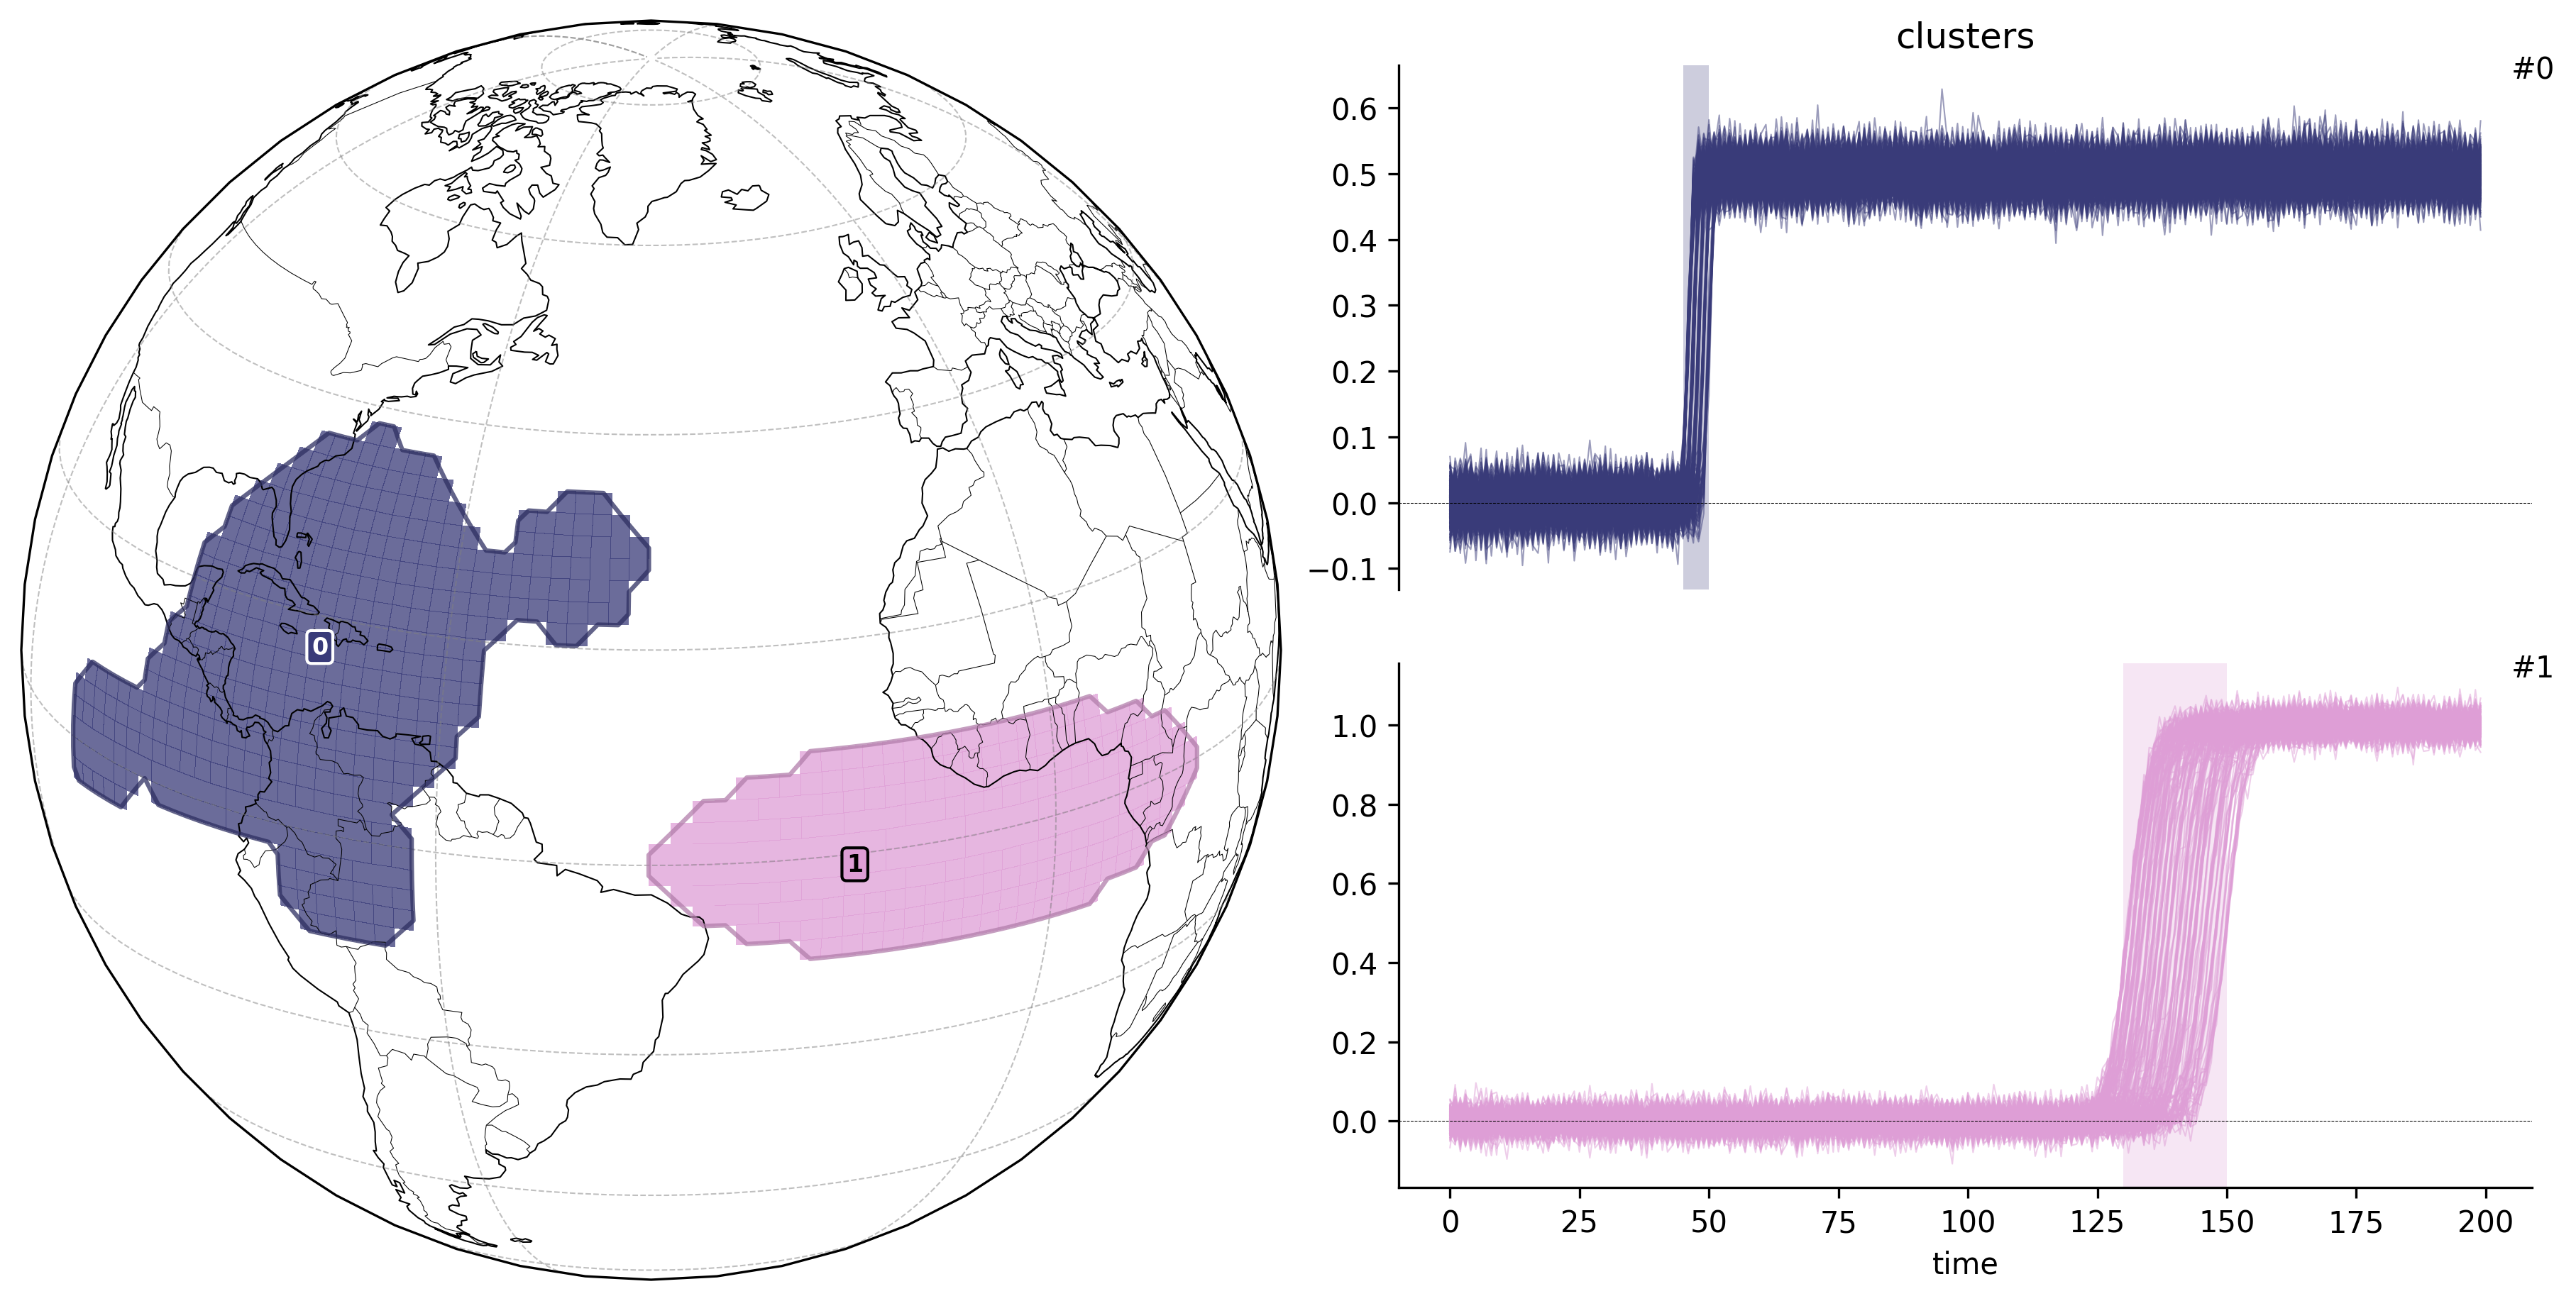

In [91]:
import cartopy.crs as ccrs

# Plot clusters
td2.plot.overview("ts", map_style={"projection": ccrs.Orthographic(-40, 20)});

# Tip: map style can also be set as a dict, instead of importing the MapStyle class